# Drowsiness detection

For this project we are going to build a CNN that detects whether in an image the eyes are open or closed.
<br>This model is going to be the core of an application that can be used for drowsiness detection.
<br>By placing the phone in front of the driver (with a specific phone holder provided) the app will function as a safety device.
<br>It will be tracking the eye of the driver and in case the eyes close the app will produce a loud sound in order to wake the drive up.
<br>This app can be a very useful safety tool as many of the accidents that happen to driver are related to driving while overly tired.
<br>In the first part of this project we will create and improve the CNN model that detects the images.

### Imports
Let us import all the necessary libraries

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os

import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from lime import lime_image
from skimage.segmentation import mark_boundaries

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

## The data
Next we are going to load and preview the data and check if any pre-processing is necessary.
<br>The data is taken from kaggle at the following [Link](https:https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset).
<br>It contains 4000 images, equally divided (as we will see) between pictures of eyes open and eyes closed.
<br>The original size of the images is 256x256 pixels.

Let us try to preview some of our data

In [2]:
# Directory path
data_dir = 'data/'

In [3]:
# Get all the data in the directory data/validation (132 images), and reshape them
img_generator = ImageDataGenerator().flow_from_directory(data_dir, batch_size=4000)
images, labels = next(img_generator)

Found 4000 images belonging to 2 classes.


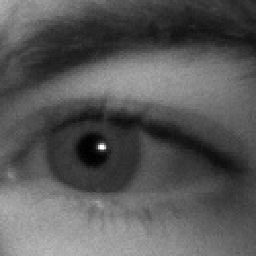

In [34]:
# Preview an image
array_to_img(images[0])

Let us take a look at the images shape:

In [5]:
images.shape

(4000, 256, 256, 3)

This shows us that we have 4000 images and their size is 256x256 pixels.

In [6]:
images[0]

array([[[178., 178., 178.],
        [178., 178., 178.],
        [168., 168., 168.],
        ...,
        [ 39.,  39.,  39.],
        [ 39.,  39.,  39.],
        [ 39.,  39.,  39.]],

       [[178., 178., 178.],
        [178., 178., 178.],
        [168., 168., 168.],
        ...,
        [ 39.,  39.,  39.],
        [ 39.,  39.,  39.],
        [ 39.,  39.,  39.]],

       [[167., 167., 167.],
        [167., 167., 167.],
        [160., 160., 160.],
        ...,
        [ 43.,  43.,  43.],
        [ 40.,  40.,  40.],
        [ 40.,  40.,  40.]],

       ...,

       [[123., 123., 123.],
        [123., 123., 123.],
        [133., 133., 133.],
        ...,
        [ 89.,  89.,  89.],
        [ 90.,  90.,  90.],
        [ 90.,  90.,  90.]],

       [[124., 124., 124.],
        [124., 124., 124.],
        [124., 124., 124.],
        ...,
        [ 95.,  95.,  95.],
        [ 93.,  93.,  93.],
        [ 93.,  93.,  93.]],

       [[124., 124., 124.],
        [124., 124., 124.],
        [124., 1

Now let's preview the labels:

In [35]:
labels[0]

array([0., 1.], dtype=float32)

In [8]:
labels[1]

array([0., 1.], dtype=float32)

Viewing the class indexes.

In [9]:
img_generator.class_indices

{'Closed_Eyes': 0, 'Open_Eyes': 1}

Preview one more image.

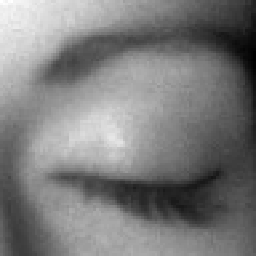

In [40]:
# Preview an image
array_to_img(images[4])

In [11]:
labels[6]

array([1., 0.], dtype=float32)

Looking at the shape of the labels.

In [12]:
labels.shape

(4000, 2)

In [13]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

Now we are going to extract only the first one of the two columns, so that 1 means 'open' and 0 means 'closed'.

In [14]:
labs=labels[:,1]

In [15]:
labs.shape

(4000,)

In [36]:
labs[0]

1.0

In [41]:
labs[4]

0.0

### Creating a Train and Test Split

Next we are going to create a Test sub-folder and copy some of the images there to keep aside as a final set of images to test on and to act as 'unseen data'.
<br>First creating the necessary directories:

In [42]:
new_dir_train = 'data/train'
new_dir_test = 'data/test'
new_dir_train_open = 'data/train/open'
new_dir_train_closed = 'data/train/closed'
new_dir_test_open = 'data/test/open'
new_dir_test_closed = 'data/test/closed'

The next code block created the new folders.
I ran this code only once and then commented it out since we don't need to recreate the folders at every re run of the code, but I left it for reference and reproducibility.

In [43]:
"""# Code to create the new folder 'binary'
os.mkdir(new_dir_train)
os.mkdir(new_dir_test)
os.mkdir(new_dir_train_open)
os.mkdir(new_dir_train_closed)
os.mkdir(new_dir_test_open)
os.mkdir(new_dir_test_closed)
"""

Next we have to copy the images. Look at bookmarked website for reference.

### Naive Model

In [17]:
# Get all the data in the directory data/validation (132 images), and reshape them
img_generator = ImageDataGenerator().flow_from_directory(
    data_dir, target_size=(32, 32), batch_size=4000)
images_32, labels_32 = next(img_generator)

Found 4000 images belonging to 2 classes.


In [18]:
labels_32=labels_32[:,1]

Let us find out if the classes are balanced:

In [19]:
print(f"number of non-zero: {np.count_nonzero(labels_32)}" )
print(f"number of zeros: {labels_32.size - np.count_nonzero(labels_32)}")

number of non-zero: 2000
number of zeros: 2000


Perfect, they are. Now let us create our first naive model:

In [20]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(32,32,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [21]:
X=images_32
y=labels_32

In [22]:
history = model.fit(X, y, epochs=15, batch_size=10, 
                        validation_split=0.2, verbose=1)

Epoch 1/15
320/320 [==============================] - 9s 18ms/step - loss: 3.7841 - acc: 0.6842 - val_loss: 0.3067 - val_acc: 0.9075
Epoch 2/15
320/320 [==============================] - 2s 7ms/step - loss: 0.2038 - acc: 0.9321 - val_loss: 0.1423 - val_acc: 0.9525
Epoch 3/15
320/320 [==============================] - 3s 8ms/step - loss: 0.1283 - acc: 0.9596 - val_loss: 0.1021 - val_acc: 0.9650
Epoch 4/15
320/320 [==============================] - 3s 9ms/step - loss: 0.0912 - acc: 0.9696 - val_loss: 0.1731 - val_acc: 0.9300
Epoch 5/15
320/320 [==============================] - 2s 6ms/step - loss: 0.0758 - acc: 0.9792 - val_loss: 0.0956 - val_acc: 0.9725
Epoch 6/15
320/320 [==============================] - 3s 10ms/step - loss: 0.0682 - acc: 0.9780 - val_loss: 0.0718 - val_acc: 0.9762
Epoch 7/15
320/320 [==============================] - 3s 11ms/step - loss: 0.0521 - acc: 0.9857 - val_loss: 0.0788 - val_acc: 0.9750
Epoch 8/15
320/320 [==============================] - 3s 9ms/step - loss:

Defining some functions to evaluate the model:

In [23]:
def visualize_training_results(results):
#Extracting the history from the results of the model
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
#Plotting Train and Validation Accuracy
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
#Setting legend, title and labels
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
#Plotting Train and Validation Loss    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
#Setting legend, title and labels
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

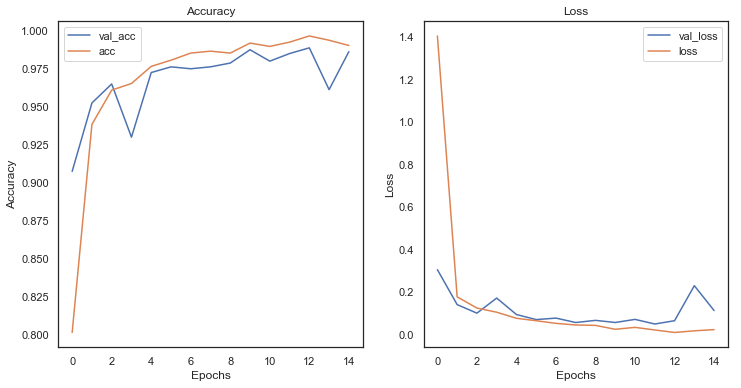

In [24]:
visualize_training_results(history)

In [25]:
def conf_matrix(model, trainX, trainy):
    seed = 42
    tf.random.set_seed(seed)
#    y_pred_prob = model.predict(trainX, verbose=0)
    # predict classes
    y_pred_clas = (model.predict(trainX) > 0.5).astype("float")
    # confusion matrix
    cnm = confusion_matrix(trainy, y_pred_clas)
    # To Normalize
    cnm = cnm.astype('float') / cnm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cnm, annot=True, fmt='.2f', cmap="Oranges")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show(block=False)

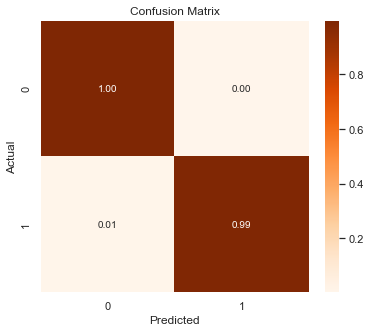

In [26]:
conf_matrix(model, X, y)

Let us see what happens increasing the size of the images:

In [27]:
# Get all the data in the directory data/validation (132 images), and reshape them
img_generator = ImageDataGenerator().flow_from_directory(
    data_dir, target_size=(64, 64), batch_size=4000)
images_64, labels_64 = next(img_generator)

Found 4000 images belonging to 2 classes.


In [28]:
labels_64=labels_64[:,1]

In [29]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(64,64,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [30]:
X=images_64
y=labels_64

In [31]:
history = model.fit(X, y, epochs=15, batch_size=10, 
                        validation_split=0.2, verbose=1)

Epoch 1/15
320/320 [==============================] - 5s 13ms/step - loss: 3.3749 - acc: 0.7667 - val_loss: 0.1779 - val_acc: 0.9525
Epoch 2/15
320/320 [==============================] - 4s 14ms/step - loss: 0.1429 - acc: 0.9479 - val_loss: 0.2576 - val_acc: 0.9137
Epoch 3/15
320/320 [==============================] - 4s 14ms/step - loss: 0.0851 - acc: 0.9725 - val_loss: 0.1465 - val_acc: 0.9613
Epoch 4/15
320/320 [==============================] - 4s 13ms/step - loss: 0.0365 - acc: 0.9859 - val_loss: 0.1990 - val_acc: 0.9500
Epoch 5/15
320/320 [==============================] - 4s 14ms/step - loss: 0.0767 - acc: 0.9745 - val_loss: 0.1662 - val_acc: 0.9400
Epoch 6/15
320/320 [==============================] - 4s 13ms/step - loss: 0.0672 - acc: 0.9746 - val_loss: 0.1101 - val_acc: 0.9737
Epoch 7/15
320/320 [==============================] - 4s 13ms/step - loss: 0.0437 - acc: 0.9846 - val_loss: 0.2145 - val_acc: 0.9613
Epoch 8/15
320/320 [==============================] - 4s 12ms/step - 

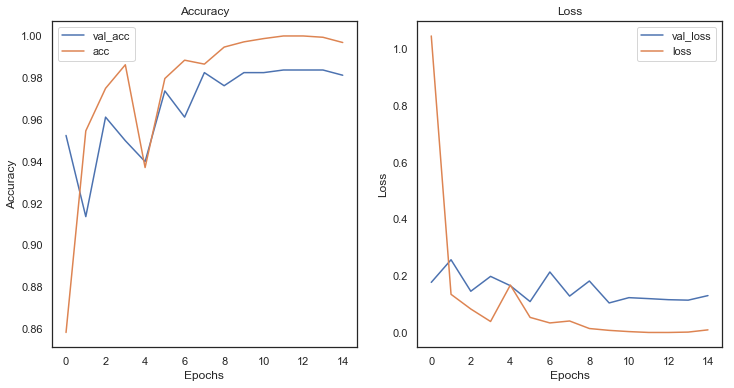

In [32]:
visualize_training_results(history)

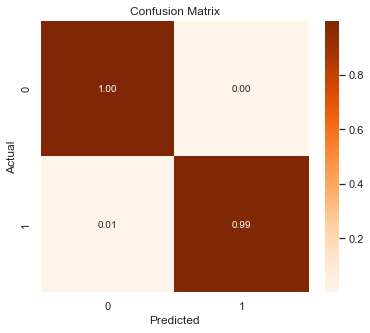

In [33]:
conf_matrix(model, X, y)